In [197]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import Sequential # sequential model: https://keras.io/guides/sequential_model/
from keras.layers import Dense, Dropout, Input
from keras.regularizers import l2
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

### Read the data

In [198]:
df1 = pd.read_csv("FINAL1.csv")
df2 = pd.read_csv("FINAL2.csv")

In [199]:
df1["total minutes of parking"].describe()

count    16992.000000
mean       651.370338
std       1103.611650
min          0.000000
25%          0.000000
50%         60.000000
75%        708.333333
max       3120.000000
Name: total minutes of parking, dtype: float64

In [200]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16992 entries, 0 to 16991
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   datetime                  16992 non-null  object 
 1   hour                      16992 non-null  int64  
 2   weekday                   16992 non-null  int64  
 3   dayOfMonth                16992 non-null  int64  
 4   month                     16992 non-null  int64  
 5   year                      16992 non-null  int64  
 6   total number of sessions  16992 non-null  int64  
 7   total minutes of parking  16992 non-null  float64
 8   temperature               16992 non-null  float64
 9   cloud_cover               16992 non-null  float64
 10  pressure                  16992 non-null  float64
 11  windspeed                 16992 non-null  float64
 12  precipitation             16992 non-null  float64
dtypes: float64(6), int64(6), object(1)
memory usage: 1.7+ MB


In the ARIMA model, we discovered that certain holidays play a very important role, so we add that feature quickly with a function and convert True/False to binary values

In [201]:
df1["datetime"] = pd.to_datetime(df1["datetime"])
df2["datetime"] = pd.to_datetime(df2["datetime"])
cal = calendar()
holidays = cal.holidays(start=df1["datetime"].min(), end=df1["datetime"].max())
df1["holiday"] = df1["datetime"].isin(holidays)
df2["holiday"] = df2["datetime"].isin(holidays)
df1["holiday"] = df1["holiday"].astype(int)
df2["holiday"] = df2["holiday"].astype(int)
df1

,datetime,hour,weekday,dayOfMonth,month,year,total number of sessions,total minutes of parking,temperature,cloud_cover,pressure,windspeed,precipitation,holiday
0,2018-04-24 00:00:00,0,1,24,4,2018,0,0.000000,24.0,30.0,985.82,19.0,0.0,0
1,2018-04-24 01:00:00,1,1,24,4,2018,0,0.000000,25.0,30.0,985.49,17.0,0.0,0
2,2018-04-24 02:00:00,2,1,24,4,2018,0,0.000000,20.0,30.0,985.82,15.0,0.0,0
3,2018-04-24 03:00:00,3,1,24,4,2018,0,0.000000,17.0,29.0,986.48,17.0,0.0,0
4,2018-04-24 04:00:00,4,1,24,4,2018,0,0.000000,16.0,29.0,987.14,9.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16987,2020-03-31 19:00:00,19,1,31,3,2020,1,37.083333,22.0,34.0,988.45,11.0,0.0,0
16988,2020-03-31 20:00:00,20,1,31,3,2020,0,0.000000,23.0,34.0,987.47,13.0,0.0,0
16989,2020-03-31 21:00:00,21,1,31,3,2020,0,0.000000,24.0,34.0,986.48,11.0,0.0,0
16990,2020-03-31 22:00:00,22,1,31,3,2020,0,0.000000,25.0,34.0,985.82,11.0,0.0,0


### Since we dont need datetime for the prediction and dont know the total number of sessions, we remove the columns

In [202]:
df1 = df1.drop("datetime", axis=1)
df2 = df2.drop("datetime", axis=1)
df1 = df1.drop("total number of sessions", axis=1)
df2 = df2.drop("total number of sessions", axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16992 entries, 0 to 16991
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   hour                      16992 non-null  int64  
 1   weekday                   16992 non-null  int64  
 2   dayOfMonth                16992 non-null  int64  
 3   month                     16992 non-null  int64  
 4   year                      16992 non-null  int64  
 5   total minutes of parking  16992 non-null  float64
 6   temperature               16992 non-null  float64
 7   cloud_cover               16992 non-null  float64
 8   pressure                  16992 non-null  float64
 9   windspeed                 16992 non-null  float64
 10  precipitation             16992 non-null  float64
 11  holiday                   16992 non-null  int32  
dtypes: float64(6), int32(1), int64(5)
memory usage: 1.5 MB


### Extracting the feature we want to predict and then we split into train, validation and test set. For now only one for transparency reasons

In [203]:
y = df1["total minutes of parking"]
y = pd.DataFrame(y)
X = df1.drop("total minutes of parking", axis=1)

### Split the data into training, holdout and test set.

In [204]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

X_train, y_train = 60% = training set

X_val, y_val     = 20% = validation set

X_test, y_test   = 20% = test set

### Now we scale the training, validation and test sets

In [205]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Next we build the sequential NN

In [206]:
neuralnetwork = Sequential()

neuralnetwork.add(Input(shape=(11,)))
neuralnetwork.add(Dense(89, activation="relu", kernel_regularizer=l2(0.004)))
neuralnetwork.add(Dropout(0.055))
neuralnetwork.add(Dense(89, activation="relu", kernel_regularizer=l2(0.004)))
neuralnetwork.add(Dropout(0.055))
neuralnetwork.add(Dense(89, activation="relu", kernel_regularizer=l2(0.004)))
neuralnetwork.add(Dropout(0.055))
neuralnetwork.add(Dense(89, activation="relu", kernel_regularizer=l2(0.004)))
neuralnetwork.add(Dropout(0.055))
neuralnetwork.add(Dense(89, activation="relu", kernel_regularizer=l2(0.004)))
neuralnetwork.add(Dropout(0.055))
neuralnetwork.add(Dense(1))

### Comile the model

In [207]:
neuralnetwork.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])

### Fitting/Training the NN

In [208]:
history = neuralnetwork.fit(X_train_scaled, y_train,
                            validation_data=(X_val_scaled, y_val),  # Pass validation data
                            epochs=81,
                            batch_size=30)

Epoch 1/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1204897.5000 - mae: 679.0293 - mse: 1204896.0000 - val_loss: 780037.1250 - val_mae: 559.1518 - val_mse: 780035.6250
Epoch 2/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 685314.8750 - mae: 519.7011 - mse: 685312.6875 - val_loss: 399303.5938 - val_mae: 369.6894 - val_mse: 399301.0625
Epoch 3/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 386029.4375 - mae: 357.2732 - mse: 386026.9062 - val_loss: 259794.6406 - val_mae: 266.1246 - val_mse: 259791.8906
Epoch 4/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 279952.9062 - mae: 282.2611 - mse: 279950.1250 - val_loss: 225692.3125 - val_mae: 240.1846 - val_mse: 225689.4219
Epoch 5/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 266130.9375 - mae: 270.1294 - mse: 266127.9688 - val_loss: 205146.3594 - val_mae: 217.0447 - val_mse: 205143.3594
Epoch 6/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 224515.3750 - mae: 241.5597 - mse: 224512.3594 - val_loss: 195

In [209]:
history_df = pd.DataFrame(history.history)
history_df

,loss,mae,mse,val_loss,val_mae,val_mse
0,966465.312500,648.944397,966463.812500,780037.125000,559.151794,780035.625000
1,608895.125000,477.660187,608892.750000,399303.593750,369.689423,399301.062500
2,357924.937500,334.189545,357922.468750,259794.640625,266.124634,259791.890625
3,280872.125000,280.261658,280869.468750,225692.312500,240.184601,225689.421875
4,252963.312500,261.364563,252960.187500,205146.359375,217.044678,205143.359375
...,...,...,...,...,...,...
76,50339.566406,110.163147,50324.644531,44960.765625,92.728073,44945.781250
77,48367.148438,108.433113,48352.164062,34777.425781,86.003281,34762.394531
78,47416.480469,106.931282,47401.437500,37916.750000,95.023499,37901.636719
79,45753.628906,105.182053,45738.445312,38752.359375,90.152184,38737.132812


In [210]:
root_metrics_df = history_df[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_df.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
root_metrics_df

,rmse,val_rmse
0,983.088914,883.196255
1,780.315801,631.902732
2,598.266219,509.697842
3,529.971196,475.067808
4,502.951476,452.927543
...,...,...
76,224.331550,212.004201
77,219.891255,186.446761
78,217.718712,194.683427
79,213.865484,196.817511


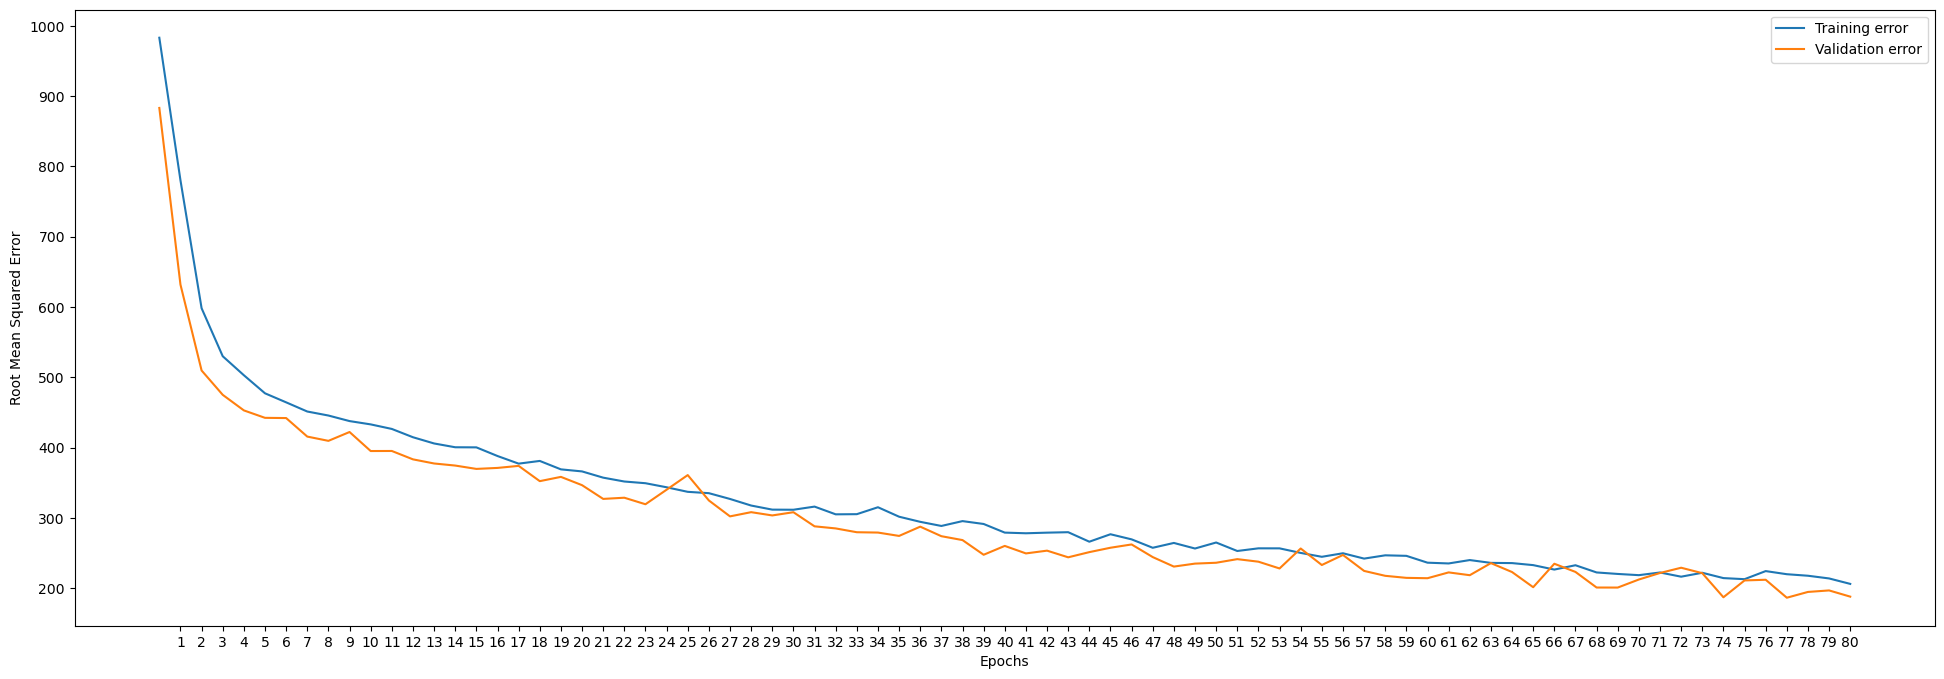

In [211]:
plt.Figure(figsize=(14,6), dpi=100)

plt.plot(root_metrics_df["rmse"], label = 'Training error')
plt.plot(root_metrics_df["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

# plt.xlim([0, epochs])
plt.xticks(range(1,81))
plt.legend()
plt.gcf().set_size_inches(24, 8)
plt.show()

### Prediction on test set

In [212]:
y_pred = neuralnetwork.predict(X_test_scaled)

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [213]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


print("Test MAPE: ", mean_absolute_percentage_error(y_test, y_pred))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))

Test MAPE:  4.273863025482235e+16
Test MAE:  86.45004577572888


### After running it several times, it averages to a MAE of 88. With domain knowledge, this MAE is actually really good, if calculated down to percentages, its a 2.8% (88/3120) mean error.

Since there are 52 spaces, there are 52x60=3120 total minutes each hour. Thats where the 2.8% comes from

### Now for Site 2. Since we already have all the Code and explained it above, we just condense it.

In [91]:
# define x and Y
y = df2["total minutes of parking"]
y = pd.DataFrame(y)
X = df2.drop("total minutes of parking", axis=1)

# Conduct train test split
from sklearn.model_selection import train_test_split

# First, split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Next, split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

# Scale training, validation, and test sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

neuralnetwork2 = Sequential()

neuralnetwork2.add(Input(shape=(11,)))
neuralnetwork2.add(Dense(89, activation="relu", kernel_regularizer=l2(0.004)))
neuralnetwork2.add(Dropout(0.055))
neuralnetwork2.add(Dense(89, activation="relu", kernel_regularizer=l2(0.004)))
neuralnetwork2.add(Dropout(0.055))
neuralnetwork2.add(Dense(89, activation="relu", kernel_regularizer=l2(0.004)))
neuralnetwork2.add(Dropout(0.055))
neuralnetwork2.add(Dense(89, activation="relu", kernel_regularizer=l2(0.004)))
neuralnetwork2.add(Dropout(0.055))
neuralnetwork2.add(Dense(89, activation="relu", kernel_regularizer=l2(0.004)))
neuralnetwork2.add(Dropout(0.055))
neuralnetwork2.add(Dense(1))

neuralnetwork2.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])

### Do the model training extra, so that it is executable separatly, as it produces live output data

In [92]:
history = neuralnetwork2.fit(X_train_scaled, y_train,
                            validation_data=(X_val_scaled, y_val),  # Pass validation data
                            epochs=81,
                            batch_size=30)

Epoch 1/81


340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 510301.8438 - mae: 483.9468 - mse: 510300.3438 - val_loss: 248954.8438 - val_mae: 353.4237 - val_mse: 248953.0781
Epoch 2/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 219498.0000 - mae: 323.3036 - mse: 219496.0781 - val_loss: 112730.6719 - val_mae: 219.5274 - val_mse: 112728.3047
Epoch 3/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 114011.6562 - mae: 223.1607 - mse: 114009.2500 - val_loss: 77601.0938 - val_mae: 174.4111 - val_mse: 77598.5234
Epoch 4/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 93042.0234 - mae: 194.4314 - mse: 93039.4297 - val_loss: 72105.1953 - val_mae: 164.8016 - val_mse: 72102.4922
Epoch 5/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 80869.3516 - mae: 180.3076 - mse: 80866.6172 - val_loss: 64477.8203 - val_mae: 153.7118 - val_mse: 64474.9922
Epoch 6/81
340/340 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 71708.6875 - mae: 168.6949 - mse: 71705.8516 - val_loss: 62340.4727 - val_mae: 150.46

In [94]:
history_df = pd.DataFrame(history.history)
root_metrics_df = history_df[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_df.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)
y_pred = neuralnetwork2.predict(X_test_scaled)
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
print("Test MAPE: ", mean_absolute_percentage_error(y_test, y_pred))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MAPE:  2.875704342015426e+16
Test MAE:  101.60116715864702


### The second model has a slightly higher average error than the one for site 1, probably because the holidays produce less variance here

### Hyperparameter Random Search

Here we did a Random Search for near optimal hyperparameter. At least given the hardware :)

Start with the necessary imports

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from scipy.stats import uniform, randint
from sklearn.model_selection import ParameterSampler

All the stuff from the top, condensed in one cell. So we can just change the csv if we need the hyperparamters for the other site later

In [11]:
df1 = pd.read_csv("FINAL1.csv")

# Data preprocessing
df1 = df1.drop(["datetime", "total number of sessions"], axis=1)
y = df1["total minutes of parking"]
X = df1.drop("total minutes of parking", axis=1)
df1["datetime"] = pd.to_datetime(df1["datetime"])
cal = calendar()
holidays = cal.holidays(start=df1["datetime"].min(), end=df1["datetime"].max())
df1["holiday"] = df1["datetime"].isin(holidays)
df1["holiday"] = df1["holiday"].astype(int)

# Split data into training, validation, and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Our definition to build the model given random parameters

In [12]:
def build_NN(num_hidden_layers=2, units_hidden=32, dropout_rate=0.2, regularization=0.01):
    neuralnet = Sequential()
    
    neuralnet.add(Input(shape=(11,)))

    # Add hidden layers here
    for _ in range(num_hidden_layers):
        neuralnet.add(Dense(units_hidden, activation="relu", kernel_regularizer=l2(regularization)))
        neuralnet.add(Dropout(dropout_rate))

    neuralnet.add(Dense(1))

    neuralnet.compile(optimizer="adam", loss='mse', metrics=['mae', 'mse'])
    
    return neuralnet


Randomly generated hyperparameters

In [13]:
distributions = {
    'num_hidden_layers': randint(1, 8),
    'units_hidden': randint(8, 100),
    'dropout_rate': uniform(0.01, 0.5),
    'epochs': randint(20, 100),
    'batch_size': randint(16, 64),
    'regularization': uniform(0.0001, 0.01)
}

Creating a list of random parameters and setting variables to save the best hyperparameters found

In [16]:
param_list = list(ParameterSampler(distributions, n_iter=10, random_state=42))

best_score = float('inf')
best_params = None
best_model = None

Actual search function for the best hyperparameters. 

In [18]:
for params in param_list:
    # just to see if its working on something, as it gets very uncertain if it runs for a long time. Meaning that patience is running out and this helps to keep waiting and see progress :D
    print(f"Testing combination: {params}")
    #Here we create a neuralnetwork with a random combination of hyperparameters 
    model = build_NN(
        num_hidden_layers=params['num_hidden_layers'],
        units_hidden=params['units_hidden'],
        dropout_rate=params['dropout_rate'],
        regularization=params['regularization']
    )
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # basically the same as before, just with random values for epochs and batchSize. Also a manual validation set worked much better here
    history = model.fit(
        X_train_scaled, 
        y_train, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        verbose=0, 
        validation_data=(X_val_scaled, y_val), 
        callbacks=[early_stopping]
    )
    val_loss = min(history.history['val_loss'])
    
    if val_loss < best_score:
        best_score = val_loss
        best_params = params
        best_model = model

Testing combination: {'batch_size': 54, 'dropout_rate': 0.40827149343011643, 'epochs': 34, 'num_hidden_layers': 3, 'regularization': 0.007896910002727693, 'units_hidden': 28}
Testing combination: {'batch_size': 54, 'dropout_rate': 0.23291637642679558, 'epochs': 94, 'num_hidden_layers': 3, 'regularization': 0.008761761457749352, 'units_hidden': 31}
Testing combination: {'batch_size': 18, 'dropout_rate': 0.020292247147901225, 'epochs': 21, 'num_hidden_layers': 4, 'regularization': 0.009485527090157502, 'units_hidden': 9}
Testing combination: {'batch_size': 36, 'dropout_rate': 0.3187407548138583, 'epochs': 77, 'num_hidden_layers': 6, 'regularization': 0.00017066305219717406, 'units_hidden': 96}
Testing combination: {'batch_size': 42, 'dropout_rate': 0.31592644736118974, 'epochs': 61, 'num_hidden_layers': 4, 'regularization': 0.00983755518841459, 'units_hidden': 22}
Testing combination: {'batch_size': 62, 'dropout_rate': 0.31919300466654366, 'epochs': 74, 'num_hidden_layers': 4, 'regulariz

Here we can finally see what the best hyperparameters found by the random search are

In [19]:
print("Best parameters found:")
print(best_params)
print("Best validation loss:", best_score)

Best parameters found:
{'batch_size': 36, 'dropout_rate': 0.3187407548138583, 'epochs': 77, 'num_hidden_layers': 6, 'regularization': 0.00017066305219717406, 'units_hidden': 96}
Best validation loss: 154653.234375


Now we check the actual predictive performance of the best model found by the random search

In [20]:
y_pred = best_model.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 389.1201255430936
MAE: 198.97801947867433
